# Group Project Report

#### Sarah Chenwang, Sabrina Dong, Eleanor Lam, Abian Latif

**Introduction**
The Pacific Laboratory for Artificial Intelligence (PLAI), a research group from the computer science department of the University of British Columbia, is interested in exploring the behaviour of how people play minecraft. So, they set up a minecraft server to record the play sessions of different players.

Our project aims to study the behaviours of different users to analyze the “kinds” of players that are most likely to contribute large amounts of data. We came up with the predictive question: What “kinds” of players are most likely to contribute a large amount of data so we can target those players in recruitment efforts? For our question, we will define kinds of players by their experience, hours played and whether they are subscribed or not. For large amounts of data, we will define that as players who contribute at least more than the 25th percentile of total hours played. 

We will be using the players.csv dataset which recorded data from students who played the last school year. It includes 196 observations with 9 variables including: 

In [1]:
meanings <- c("player's skill level", 
              "if player is subscribed for email updates", 
              "encrypted version of player's email",
              "total hours played by player", 
              "name of player in game", 
              "gender of player",
              "age of player",
              "player's ID",
              "player's organization")

pl_variable_frame <- data.frame("Variable" = c("Experience", "Subscribe", 
                                               "hashedEmail", "played_hours",
                                               "name", "gender", 
                                               "age", "individualId", 
                                               "organizationName"),
                                "Type" = c("Character", "Logical", "Character",
                                           "Double", "Character", "Character",
                                           "Double", "Logical", "Logical"),
                                "Meaning" = meanings)
pl_variable_frame

Variable,Type,Meaning
<chr>,<chr>,<chr>
Experience,Character,player's skill level
Subscribe,Logical,if player is subscribed for email updates
hashedEmail,Character,encrypted version of player's email
played_hours,Double,total hours played by player
name,Character,name of player in game
gender,Character,gender of player
age,Double,age of player
individualId,Logical,player's ID
organizationName,Logical,player's organization


This dataset can help determine the results of our predictive question.

**Methods & Results**

We’re using K-Nearest Neighbors (KNN) classification to determine which players are most likely to contribute a lot of data. The model uses two predictors: number_of_sessions (how often someone plays) and played_hours (how long they play overall). These predictors are quantitative indicators of player engagement and can help identify the players who contribute the most data. 

The data is scaled and centered before its use in the model since KNN uses Euclidean distance calculations to find neighbours, and having one variable predictor (like played_hours) dominate due to its larger scale would distort the analysis. Cross-validation is used to tune the number of neighbors (k) and check how well the model performs without overfitting or underfitting. 

In [1]:
library(tidyverse)

url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"

players <- read_csv(url)
# players

url2 <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
sessions <- read_csv(url2)
# sessions

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ─────────────────────────────────

In [2]:
sessions_time <- sessions |>
    mutate(start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M")) |>
    mutate(end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M")) |>
    mutate(time_difference = as.numeric(difftime(end_time, start_time, units = "mins")))
# calculates the time spent playing in minutes

sessions_grouped <- sessions_time |>
    group_by(hashedEmail) |>
    summarise(number_of_sessions = n())
# calculates the number of sessions a player has played

players_neat <- players |>
    mutate(experience= factor(experience, 
                                 levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"), 
                                 labels = c(1, 2, 3, 4, 5))) |>
    mutate(experience_numeric = as.numeric(experience), subscribe = factor(subscribe)) |>
    select(-individualId, -organizationName)

# creates extra column where experience is a numeric, so it can be plotted for our visualization
# changes experience to a factor, where
#                                 1: Beginner level
#                                 2: Amateur level
#                                 3: Regular level
#                                 4: Pro level
#                                 5: Veteran level
# removes the two uneccessary columns for our analysis
           
combined <- players_neat |>
   right_join(sessions_grouped, by = "hashedEmail") |>
    select(-experience_numeric, -name, -hashedEmail, -age)

combined_example <- combined |>
    slice_head(n = 6)

combined_example

experience,subscribe,played_hours,gender,number_of_sessions
<fct>,<fct>,<dbl>,<chr>,<int>
4,TRUE,30.3,Male,27
5,TRUE,3.8,Male,3
5,FALSE,0.0,Male,1
2,TRUE,0.7,Female,1
3,TRUE,0.1,Male,1
2,FALSE,0.0,Male,1


Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


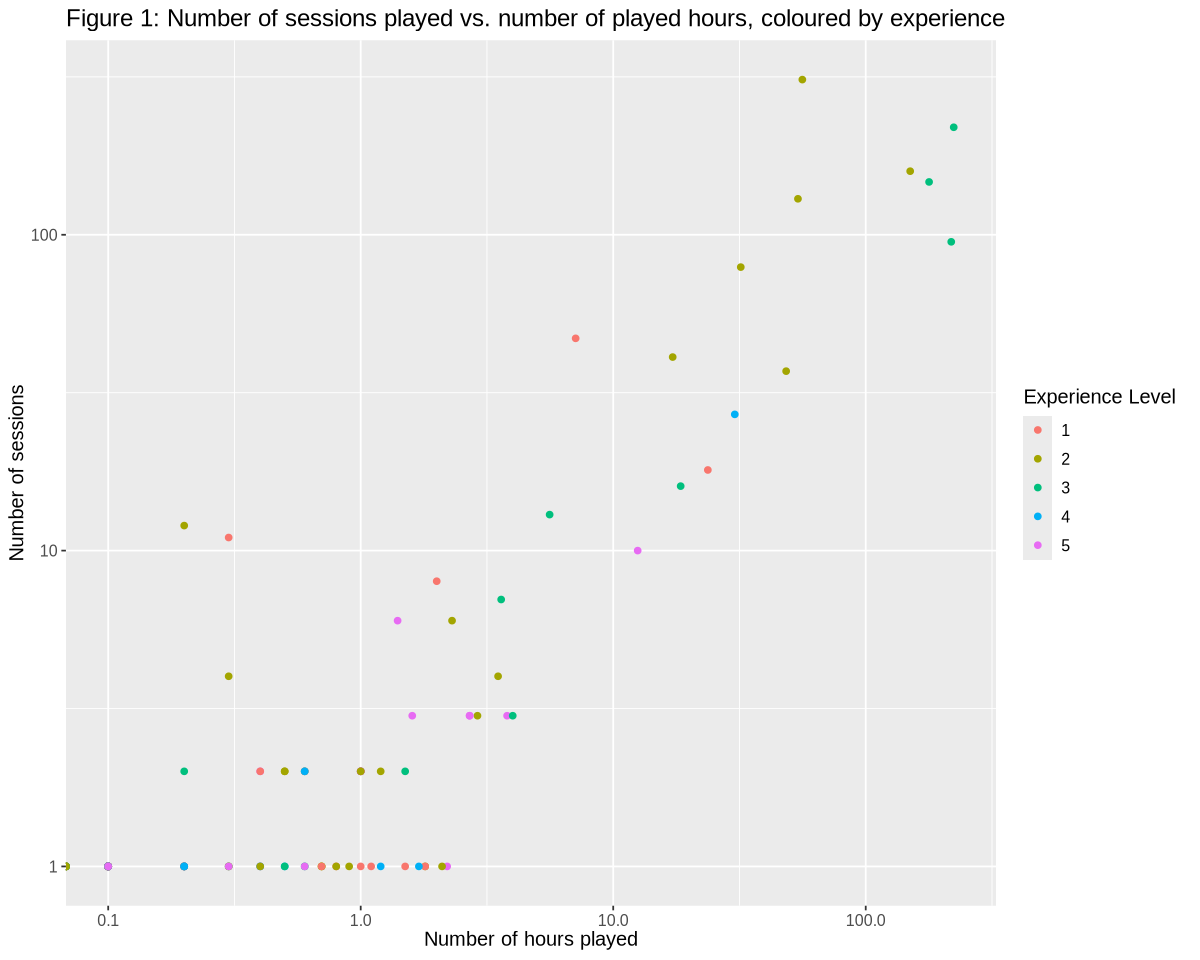

In [3]:
library(ggplot2)

options(repr.plot.height = 8, repr.plot.width = 10)

plot_experience <- combined |>
  ggplot(aes(x = played_hours, y = number_of_sessions, color = experience)) +
  geom_point() +
  labs(x = 'Number of hours played', 
       y = 'Number of sessions', 
       color = 'Experience Level',
        title = "Figure 1: Number of sessions played vs. number of played hours, coloured by experience") +
  scale_x_log10() +
  scale_y_log10() +
  theme(text = element_text(size = 12))

plot_experience

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


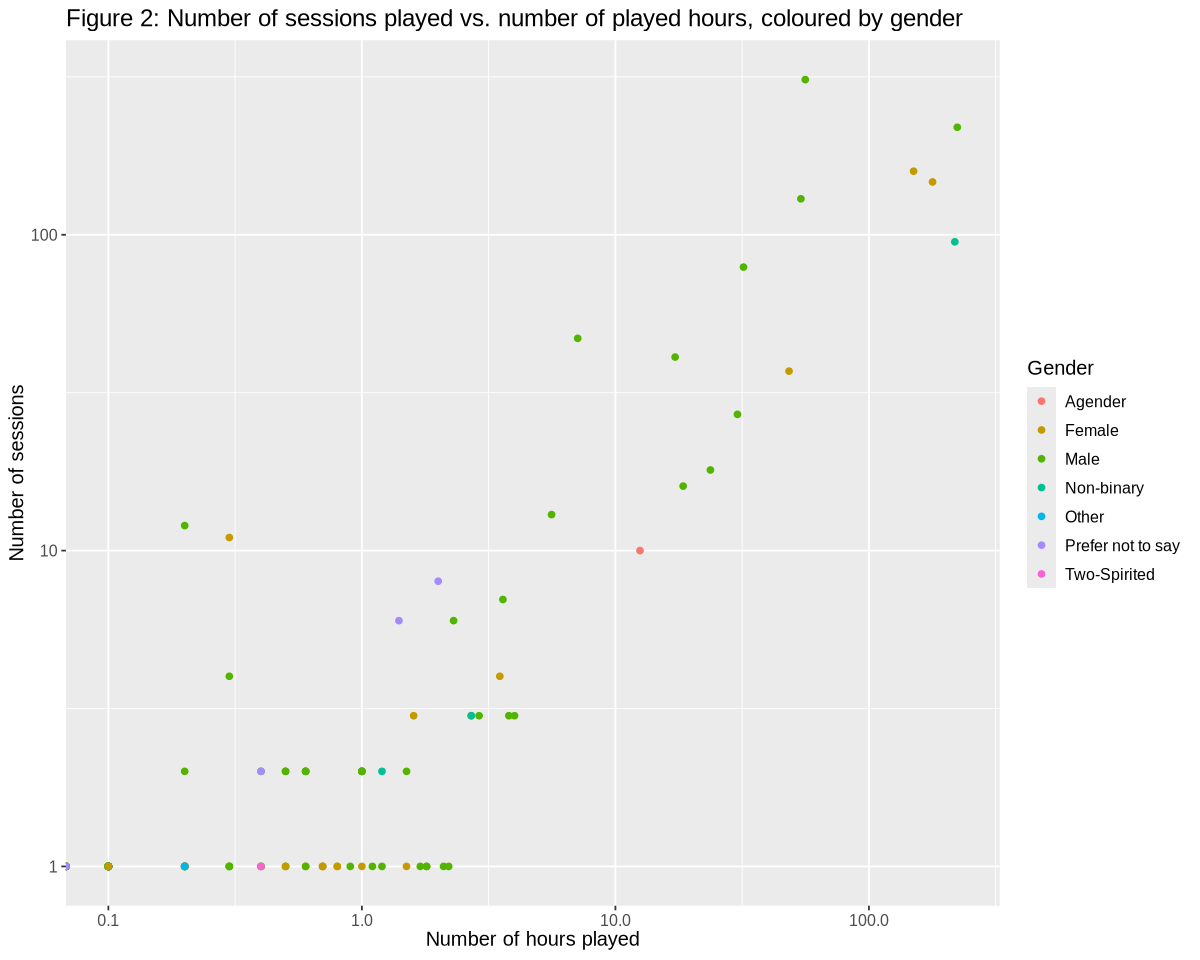

In [12]:
plot_gender <- combined |>
  ggplot(aes(x = played_hours, y = number_of_sessions, color = gender)) +
  geom_point() +
  labs(x = 'Number of hours played', 
       y = 'Number of sessions', 
       color = 'Gender',
        title = "Figure 2: Number of sessions played vs. number of played hours, coloured by gender") +
    scale_x_log10() +
  scale_y_log10() +
  theme(text = element_text(size = 12))
 options(repr.plot.height = 8, repr.plot.width = 10)
plot_gender

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


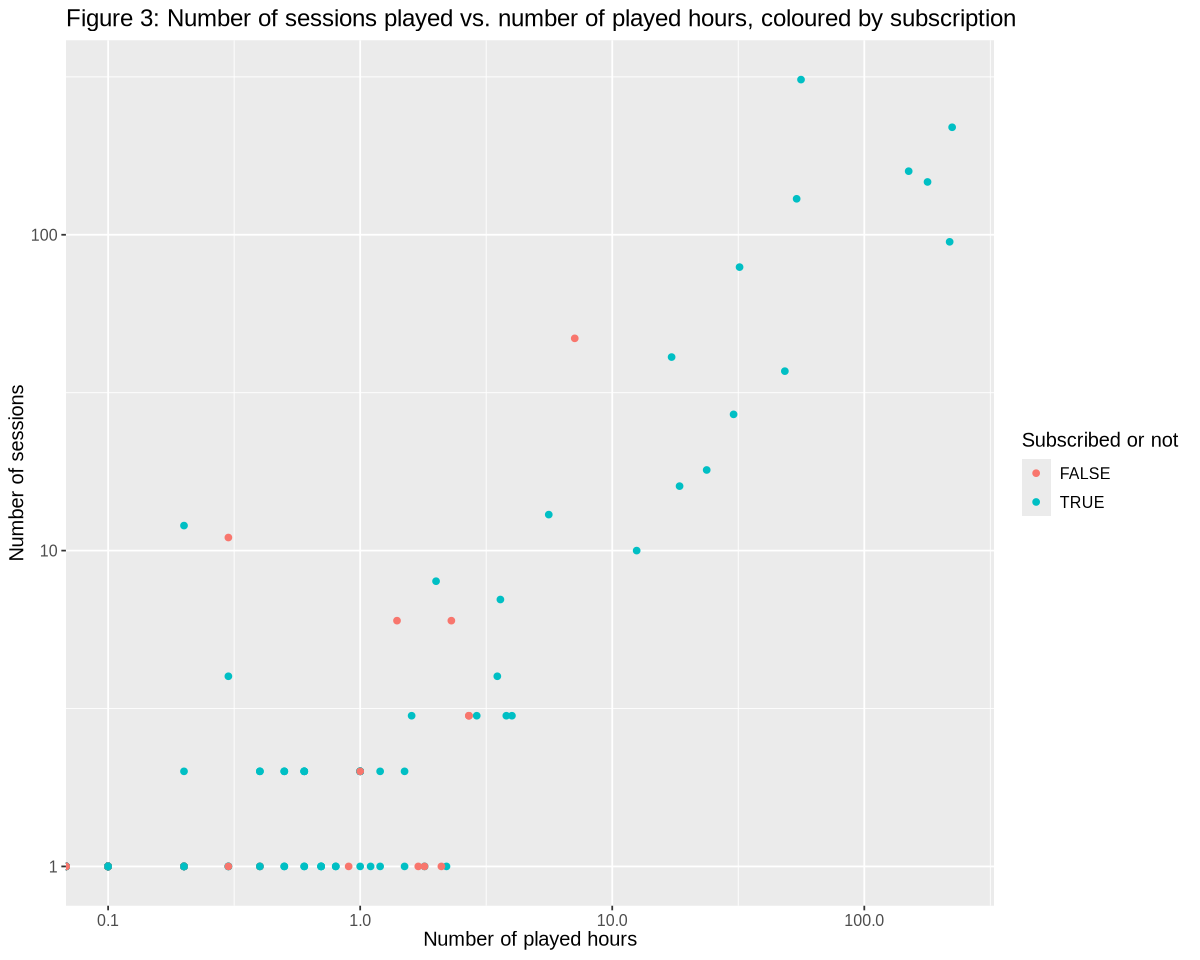

In [13]:
options(repr.plot.height = 8, repr.plot.width = 10)

plot_subscribe <- combined |>
  ggplot(aes(x = played_hours, y = number_of_sessions, color = subscribe)) +
  geom_point() +
  labs(x = 'Number of played hours', 
       y = 'Number of sessions', 
       color = 'Subscribed or not',
       title = "Figure 3: Number of sessions played vs. number of played hours, coloured by subscription") +
  scale_x_log10() +
  scale_y_log10() +
  theme(text = element_text(size = 12))

plot_subscribe

**Predictive Models**

Predictive model for experience

In [6]:
library(tidyverse)
library(tidymodels)

#sets seed
set.seed(1)

#creating prediction model based on experience
#splits data into training and testing
experience_split <- initial_split(combined, prop = 0.75, strata = experience)
experience_train <- training(experience_split)
experience_test <- testing(experience_split)

#creates model with multiple neighbors to create classification
experience_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                 set_engine("kknn") |>
                 set_mode("classification")

#creates recipe to scale predictors
exp_recipe <- recipe(experience ~ played_hours + number_of_sessions, data = experience_train) |>
                   step_scale(all_predictors()) |>
                   step_center(all_predictors())

#creates workflow
exp_workflow <- workflow() |>
                     add_recipe(exp_recipe) |>
                     add_model(experience_spec) 

# k values for neighbors
gridvals <- tibble(neighbors = seq(from = 1, to = 10))

#cross validation - 5 fold
exp_vfold <- vfold_cv(experience_train, v = 5, strata = experience)

# creates a table of metrics for each k value
exp_results <- exp_workflow |>
                        tune_grid(resamples = exp_vfold, grid = gridvals) |>
                        collect_metrics()

#filters table for accuracy and selects columns
clean_exp_results <- exp_results |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)

# exp_results

#identifies neighbors with the highest accuracy value
choose_k_exp <- clean_exp_results |>
    arrange(mean) |>
    slice_max(mean, n=1) 

choose_k_exp


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/

→ A | warning: ✖ No observations were detected in `truth` for level: 4.
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,mean
<int>,<dbl>
5,0.1974888


In [7]:
# the highest accuracy is when k=5, therefore we will develop a model with neighbors = 5

#creates model with the k value as 5
exp_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
       set_engine("kknn") |>
       set_mode("classification")

#creates a new workflow to fit the training data in
exp_fit <- workflow() |>
             add_recipe(exp_recipe) |>
             add_model(exp_spec2) |>
            fit(data = experience_train)


#predict the experience in the testing data with the trained workflow
exp_predictions <- predict(exp_fit, experience_test) |>
                        bind_cols(experience_test) 

#ensures that experience and .pred_class have the same amount of categories
exp_levels <- c("Beginner", "Amateur", "Regular", "Pro", "Veteran")


#creates metrics for testing set to obtain accuracy value
metrics_exp <- exp_predictions |>
                 # mutate(experience = factor(experience, levels = exp_levels),
                 #        .pred_class = factor(.pred_class, levels = exp_levels)) |>
                 metrics(truth = experience, estimate = .pred_class) |>
                 filter(.metric == "accuracy")

metrics_exp

#creates a confusion matrix for testing set
conf_mat_exp <- exp_predictions |>
        # mutate(experience = factor(experience, levels = exp_levels),
        #    .pred_class = factor(.pred_class, levels = exp_levels)) |>
        conf_mat(truth = experience, estimate = .pred_class)

conf_mat_exp


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.1818182


          Truth
Prediction 1 2 3 4 5
         1 1 5 1 2 6
         2 2 3 3 1 0
         3 1 1 1 0 0
         4 2 2 0 0 0
         5 0 0 1 0 1

Predictive model for gender

In [8]:
#sets seed
set.seed(1)

#creating prediction model based on gender
#splits data into training and testing
gender_split <- initial_split(combined, prop = 0.75, strata = gender)
gender_train <- training(gender_split)
gender_test <- testing(gender_split)

#creates model with multiple neighbors to create classification
gender_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                 set_engine("kknn") |>
                 set_mode("classification")

#creates recipe to scale predictors
gender_recipe <- recipe(gender ~ played_hours + number_of_sessions, data = gender_train) |>
                   step_scale(all_predictors()) |>
                   step_center(all_predictors())

#cross validation
gender_vfold <- vfold_cv(gender_train, v = 5, strata = gender)

#creates workflow
gender_workflow <- workflow() |>
                     add_recipe(gender_recipe) |>
                     add_model(gender_spec) 

# k values for neighbors
gridvals <- tibble(neighbors = seq(from = 1, to = 10))

# creates a table of metrics for each k value
gender_results <- gender_workflow |>
                        tune_grid(resamples = gender_vfold, grid = gridvals) |>
                        collect_metrics()

#filters and selects table
clean_gender_results <- gender_results |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)

#identifies neighbors with the highest accuracy value
choose_k_gender <- clean_gender_results |>
    arrange(mean) |>
    slice_max(mean, n=1) 

choose_k_gender

#creates a confusion matrix for testing set
conf_mat_exp <- exp_predictions |>
        # mutate(gender = factor(gender, levels = all_levels),
        #    .pred_class = factor(.pred_class, levels = all_levels)) |>
        conf_mat(truth = experience, estimate = .pred_class)

conf_mat_exp


→ A | warning: ✖ No observations were detected in `truth` for levels: Non-binary and Other.
               ℹ Computation will proceed by ignoring those levels.

→ B | warning: ✖ No observations were detected in `truth` for levels: Agender, Non-binary,
                 Other, and Two-Spirited.
               ℹ Computation will proceed by ignoring those levels.

→ C | warning: ✖ No observations were detected in `truth` for levels: Agender, Other, Prefer
                 not to say, and Two-Spirited.
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1   B: x2   C: x1

→ D | error:   Failed to compute `roc_auc()`.
               Caused by error in `group[estimate]`:
               ! Can't subset columns that don't exist.
               ✖ Column `.pred_Other` doesn't exist.

There were issues with some computations   A: x1   B: x2   C: x1
There were issues with some computations   A: x1   B: x2   C: x1   D: x1





neighbors,mean
<int>,<dbl>
7,0.6059942
8,0.6059942


          Truth
Prediction 1 2 3 4 5
         1 1 5 1 2 6
         2 2 3 3 1 0
         3 1 1 1 0 0
         4 2 2 0 0 0
         5 0 0 1 0 1

In [9]:
# the highest accuracy is when k=7 or 8, therefore we will develop a model with neighbors = 7, because a smaller k value 
# will result in a simpler model that is less prone to overfitting

#creates model with the k value as 7
gender_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
       set_engine("kknn") |>
       set_mode("classification")

#creates a new workflow to fit the training data in
gender_fit <- workflow() |>
             add_recipe(gender_recipe) |>
             add_model(gender_spec2) |>
            fit(data = gender_train)

#predict the gender in the testing data with the trained workflow
gender_predictions <- predict(gender_fit, gender_test) |>
                        bind_cols(gender_test) 

#ensures that gender and .pred_class have the same amount of categories
all_levels <- c("Female", "Male", "Non-binary", "Prefer not to say", "Two-Spirited", "Agender", "Other")

#creates metrics for testing set (accuracy)
metrics_gender <- gender_predictions |>
    mutate(gender = factor(gender, levels = all_levels),
           .pred_class = factor(.pred_class, levels = all_levels)) |>
  metrics(truth = gender, estimate = .pred_class) |>
  filter(.metric == "accuracy")

metrics_gender

#creates a confusion matrix for testing set
conf_mat_gender <- gender_predictions |>
        mutate(gender = factor(gender, levels = all_levels),
           .pred_class = factor(.pred_class, levels = all_levels)) |>
        conf_mat(truth = gender, estimate = .pred_class)

conf_mat_gender

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.65625


                   Truth
Prediction          Female Male Non-binary Prefer not to say Two-Spirited
  Female                 2    2          0                 0            1
  Male                   3   19          3                 1            1
  Non-binary             0    0          0                 0            0
  Prefer not to say      0    0          0                 0            0
  Two-Spirited           0    0          0                 0            0
  Agender                0    0          0                 0            0
  Other                  0    0          0                 0            0
                   Truth
Prediction          Agender Other
  Female                  0     0
  Male                    0     0
  Non-binary              0     0
  Prefer not to say       0     0
  Two-Spirited            0     0
  Agender                 0     0
  Other                   0     0

neighbors,mean
<int>,<dbl>
5,0.6204334
6,0.6204334
7,0.6204334
8,0.6204334
9,0.6204334
10,0.6204334


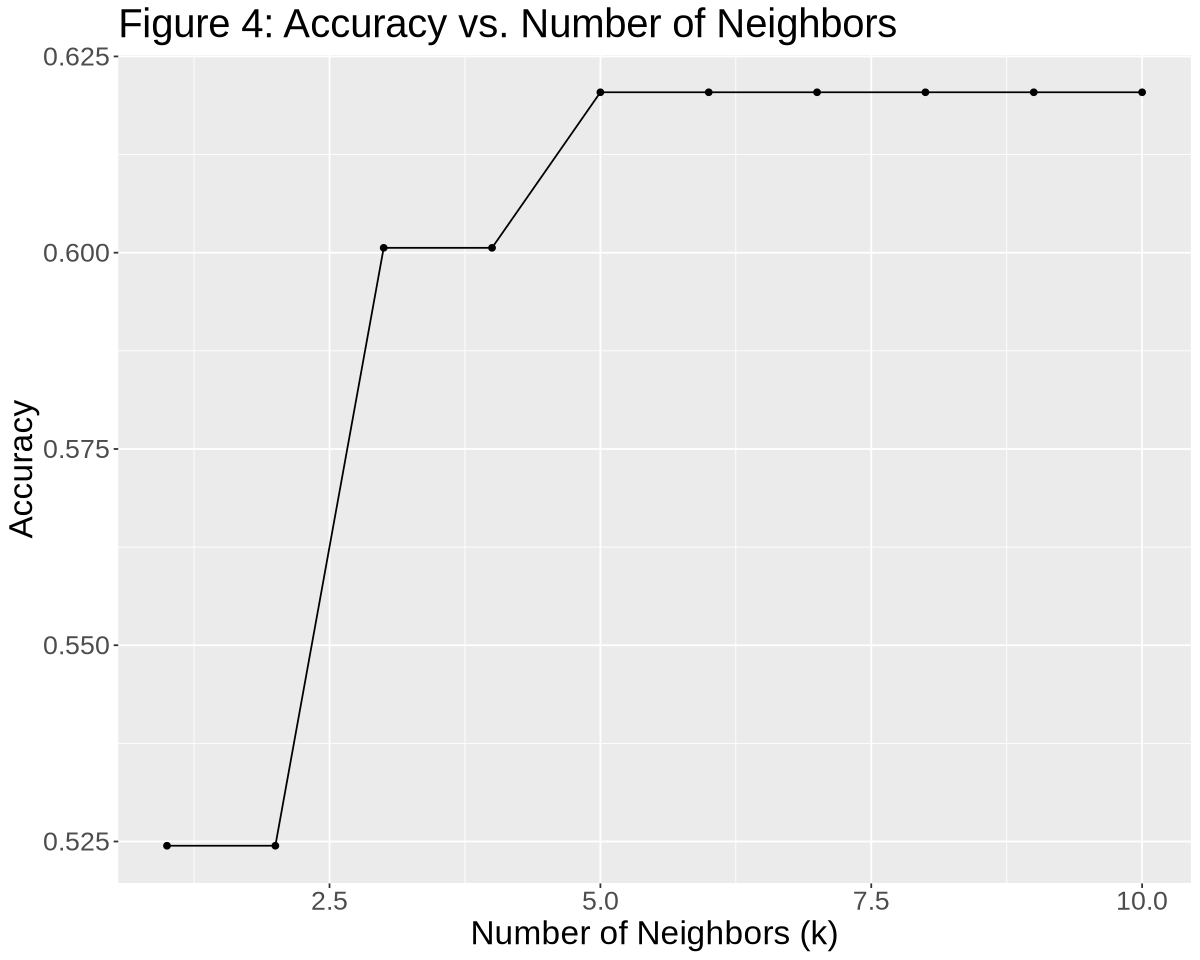

In [14]:
#sets seed
set.seed(1)

#splits data into training and testing
subscribe_split <- initial_split(combined, prop = 0.75, strata = subscribe)
subscribe_train <- training(subscribe_split)
subscribe_test <- testing(subscribe_split)

#creates model with multiple neighbors to create classification
subscribe_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                 set_engine("kknn") |>
                 set_mode("classification")

#creates recipe to scale predictors
subscribe_recipe <- recipe(subscribe ~ played_hours + number_of_sessions, data = subscribe_train) |>
                   step_scale(all_predictors()) |>
                   step_center(all_predictors())
#cross validation
subscribe_vfold <- vfold_cv(subscribe_train, v = 5, strata = subscribe)

#creates workflow
subscribe_workflow <- workflow() |>
                     add_recipe(subscribe_recipe) |>
                     add_model(subscribe_spec) 

# k values for neighbors
gridvals <- tibble(neighbors = seq(from = 1, to = 10))

# creates a table of metrics for each k value
subscribe_results <- subscribe_workflow |>
                        tune_grid(resamples = subscribe_vfold, grid = gridvals) |>
                        collect_metrics()

#filters and selects table
clean_results_subscribe <- subscribe_results |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)

#identifies neighbors with the highest accuracy value
choose_k_subscribe <- clean_results_subscribe |>
    arrange(mean) |>
    slice_max(mean, n=1) 

choose_k_subscribe

#since the highest accuracy level is the same for both neighbors = 5, 6, 7, 8, 9 and 10, we will
#graph accuracy against neighbors to have a better sense of which to pick

library(ggplot2)

plot_k <- ggplot(clean_results_subscribe, aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(title = "Figure 4: Accuracy vs. Number of Neighbors",
       x = "Number of Neighbors (k)",
       y = "Accuracy")+
    theme(text = element_text(size = 20))

plot_k


In [11]:
#since the accuracy level semes to plateau after 5 neighbors, we will build a model based off k = 5

#creates model with the k value as 5
subscribe_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
       set_engine("kknn") |>
       set_mode("classification")

#creates a new workflow to fit the training data in
subscribe_fit <- workflow() |>
             add_recipe(subscribe_recipe) |>
             add_model(subscribe_spec2) |>
            fit(data = subscribe_train)

#predict the subscription in the testing data with the trained workflow
subscribe_predictions <- predict(subscribe_fit, subscribe_test) |>
                        bind_cols(subscribe_test) 


#creates metrics for testing set (accuracy)
subscribe_metrics <- subscribe_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

subscribe_metrics

#creates a confusion matrix for testing set
conf_mat_subscribe <- subscribe_predictions |>
        conf_mat(truth = subscribe, estimate = .pred_class)

conf_mat_subscribe

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.625


          Truth
Prediction FALSE TRUE
     FALSE     3    7
     TRUE      5   17

Discussion:
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

**How well does the model work?**

Each model has a different k value that has been optimized for accuracy. The predictive model for experience was most accurate when k = 5, but overall had a lower accuracy than the gender and subscription model. The lower accuracy could be due to the lack of correlation between experience level and our predictors, number of sessions and hours played. Hence, experience level may not be an important factor during participant recruitment. 

The latter predictive models are fairly accurate in identifying players in the "high-contributor" range (those with many sessions and hours played), being 65.6% and 62.5% accurate for the gender and subscription predictive models respectively. 
However, the model struggles to predict categorical variables that are smaller groups, such as the variables "Non-binary" or "Two-Spirited" in the gender model, likely because there are insufficient examples in the dataset. This imbalance makes it harder to classify these players correctly. The log transformation for visualizations also caused some issues with infinite values, which had to be addressed during preprocessing.

**Accuracy/Precision and what it means for recruitment**

The gender and subscription predictive models are fairly accurate at classifying players who are highly engaged. Players with lots of sessions and hours–especially those who are subscribed or have prior experience–appear frequently in the "high data" category. This observation can be useful for targeting recruitment efforts since these players are most likely to contribute meaningful data.


**Challenges and limitations**

The biggest challenge is the quantitative imbalance of categorical variables values in the dataset. The lack of data for players who do not identify as "Male" or "Female" could have been a factor of the gender predictive model's lower precision. Since the majority of players identified as male or female, the other genders would not have sufficient data points to be the majority, impacting the models’ ability to make correct predictions. Resultantly, the model will not classify the data point correctly, affecting both the accuracy and inclusivity of the model.

Another consideration is the plateau in Figure 4. After k=5 in the subscription predictive model, illustrating that the model might not improve without adding new features or adjusting the dataset. The graph’s plateau of accuracy shows that while the model is performing well, there’s a limit to what it can achieve with the current data.

**Improvements for next time**

Adding more features, like patterns of playtime (e.g., time of day or session duration trends), could improve predictions as it provides additional context for engagement.
Future efforts could focus on recruiting underrepresented groups to make the dataset more balanced and inclusive. This would not only improve model accuracy but also ensure the results are more representative of all player types.


**Conclusion**

The analysis shows that the best contributors are usually players with a lot of experience, frequent sessions, and long hours played. Recruitment should focus on these players especially those who are subscribed. However, improving both the predictions and the inclusivity of the model will require addressing the dataset’s imbalances and considering new features or alternative modeling approaches.

References
You may include references if necessary, as long as they all have a consistent citation style.